# IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import random
from glob import glob
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
%matplotlib inline
# create a image generator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go
from tensorflow.keras import regularizers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')

In [4]:
data_map = []
for sub_dir_path in glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [5]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [6]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_30.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_30_mask.tif


In [7]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
'''pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 50)'''
brain_df



,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86_mask.tif,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87_mask.tif,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87_mask.tif,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88_mask.tif,0


# Phân loại

In [8]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [9]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [10]:
batch_size = 16
epochs = 100
image_size = 256

In [11]:
# split the data into train and test data
train, test = train_test_split(brain_df_train, test_size = 0.2)
# create a image generator
# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
train_datagen  = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.3,
    rotation_range=20,            # Rotate images by 20 degrees
    width_shift_range=0.1,        # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,       # Randomly shift images vertically by 10% of the height
    zoom_range=0.2,               # Apply random zooming in the range of 0.8 to 1.2
    horizontal_flip=True         # Flip images horizontally
)
     

In [12]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=batch_size,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2201 validated image filenames belonging to 2 classes.
Found 942 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


#  Phân vùng
(seg)

In [13]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [14]:
EPOCHS = 100
BATCH_SIZE = 16
learning_rate = 1e-4
im_height=256
im_width=256

In [15]:
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

In [16]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
train_count = 2201
val_count = 942
test_count = 786

# Chia tập train ban đầu
df_train_temp, df_test = train_test_split(df, test_size=test_count, random_state=42)

# Chia tập train thành tập train và tập val
df_train, df_val = train_test_split(df_train_temp, test_size=val_count, random_state=42)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2201, 2)
(942, 2)
(786, 2)


In [17]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [18]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

# Hàm hỗ trợ
(TRAIN A SEGMENTATION RESUNET MODEL TO LOCALIZE TUMOR)

In [19]:
# Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1
smooth=100


def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    binary_crossentropy_loss = K.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)
    return binary_crossentropy_loss + dice_loss

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# ResNet50-Unet

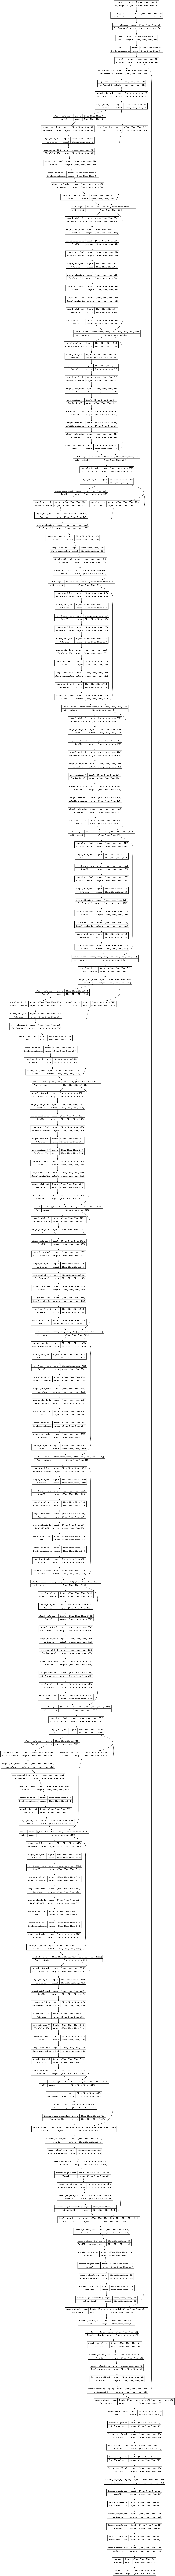

In [20]:
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 # case for binary and multiclass segmentation
activation = 'sigmoid'

#create model
model_resunet = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True)
display(tf.keras.utils.plot_model(model_resunet, to_file='model_resunet.png', show_shapes=True))


In [21]:
model_resunet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [22]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.001)
model_resunet.compile(optimizer = adam, 
                  loss = bce_dice_loss, 
                  metrics = [iou, dice_coef, 'accuracy']
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="seg_ResUNet.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

In [23]:
start_time = time.time()
history_resunet = model_resunet.fit(
                    train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks = [checkpointer, earlystopping, reduce_lr],
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE
                 )
end_time = time.time()
ResUnet_time = end_time-start_time


Found 2201 validated image filenames.
Found 2201 validated image filenames.
Epoch 1/100
138/137 [==============================] - ETA: 0s - loss: 0.7835 - iou: 0.2111 - dice_coef: 0.3162 - accuracy: 0.9787Found 942 validated image filenames.
Found 942 validated image filenames.

Epoch 1: val_loss improved from inf to 1.03060, saving model to seg_ResUNet.hdf5
137/137 [==============================] - 122s 637ms/step - loss: 0.7835 - iou: 0.2111 - dice_coef: 0.3162 - accuracy: 0.9787 - val_loss: 1.0306 - val_iou: 0.0133 - val_dice_coef: 0.0224 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 2/100
138/137 [==============================] - ETA: 0s - loss: 0.4730 - iou: 0.4126 - dice_coef: 0.5665 - accuracy: 0.9924
Epoch 2: val_loss improved from 1.03060 to 0.88614, saving model to seg_ResUNet.hdf5
137/137 [==============================] - 60s 438ms/step - loss: 0.4730 - iou: 0.4126 - dice_coef: 0.5665 - accuracy: 0.9924 - val_loss: 0.8861 - val_iou: 0.1165 - val_dice_coef: 0.1839 - val_accur

In [24]:
history_resunet.history.keys()

dict_keys(['loss', 'iou', 'dice_coef', 'accuracy', 'val_loss', 'val_iou', 'val_dice_coef', 'val_accuracy', 'lr'])

In [25]:
ResUnet_time

5954.267118215561

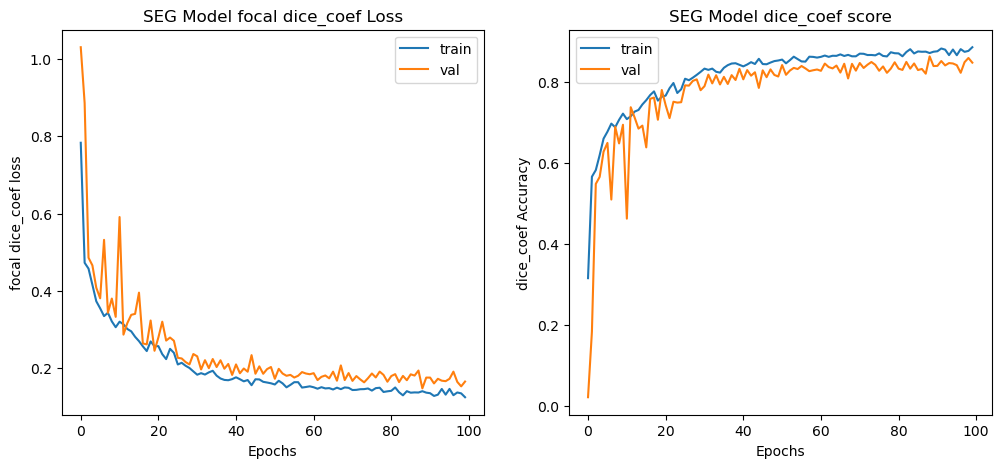

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_resunet.history['loss']);
plt.plot(history_resunet.history['val_loss']);
plt.title("SEG Model focal dice_coef Loss");
plt.ylabel("focal dice_coef loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history_resunet.history['dice_coef']);
plt.plot(history_resunet.history['val_dice_coef']);
plt.title("SEG Model dice_coef score");
plt.ylabel("dice_coef Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [27]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results_resunet = model_resunet.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

print("Test lost {:.2f}%".format(results_resunet[0]*100))
print("Test iou {:.2f}%".format(results_resunet[1]*100))
print("Test Dice Coefficent: {:.2f}%".format(results_resunet[2]*100))
print("Test Accuracy: {:.2f}%".format(results_resunet[3]*100))

Found 786 validated image filenames.
Found 786 validated image filenames.
49/49 [==============================] - 8s 156ms/step - loss: 0.1661 - iou: 0.7471 - dice_coef: 0.8500 - accuracy: 0.9974
Test lost 16.61%
Test iou 74.71%
Test Dice Coefficent: 85.00%
Test Accuracy: 99.74%


1/1 [==============================] - 2s 2s/step


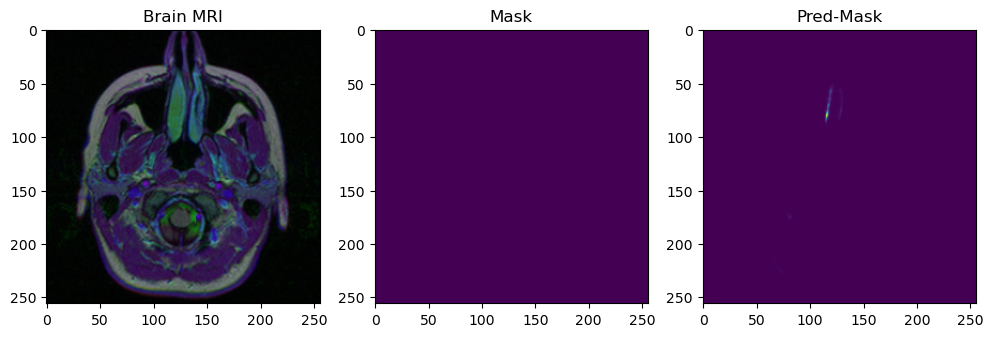

1/1 [==============================] - 0s 25ms/step


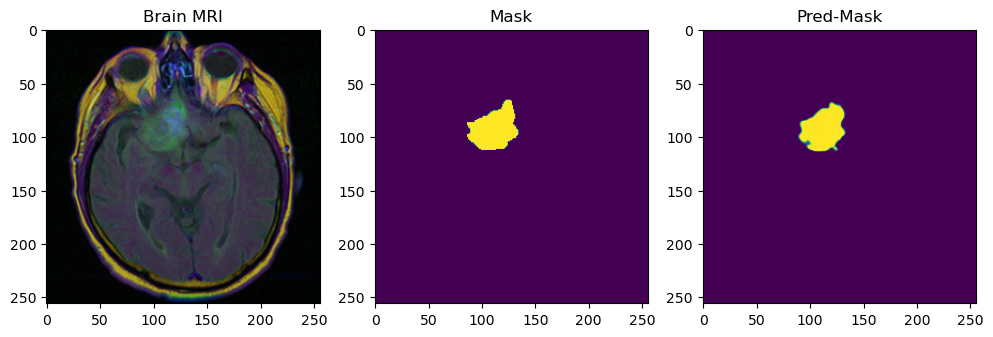

In [28]:
try:
    image=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif')
    image=cv2.resize(image,dsize=(256,256))
    image=image /255.0
    image_ex=np.expand_dims(image,axis=0)
    image_mask=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif')
    image_mask=cv2.resize(image_mask,dsize=(256,256))
    image_mask=image_mask /255.0
    image_mask_ex=np.expand_dims(image_mask,axis=0)

    # Make prediction
    prediction = model_resunet.predict(image_ex)
    # Chuyển đổi đầu ra dự đoán và mặt nạ thực thành dạng nhị phân
    threshold = 0.01
    predicted_mask = np.round(prediction> threshold)
    true_mask = np.round(image_mask_ex> threshold)  # Thay true_mask bằng mặt nạ thực của bạn

    # Tính toán phần trăm chính xác
    accuracy = np.mean(predicted_mask == true_mask) * 100
    #print("Phần trăm chính xác: {:.2f}%".format(accuracy))
    # In kết quả

    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Brain MRI");
    plt.subplot(1,3,2)
    plt.imshow(image_mask)
    plt.title("Mask");
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(prediction))
    plt.title("Pred-Mask");
    plt.show()
    print("===========================================================================================================")

    image=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif')
    image=cv2.resize(image,dsize=(256,256))
    image=image /255.0
    image_ex=np.expand_dims(image,axis=0)
    image_mask=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif')
    image_mask=cv2.resize(image_mask,dsize=(256,256))
    image_mask=image_mask /255.0
    image_mask_ex=np.expand_dims(image_mask,axis=0)

    # Make prediction
    prediction = model_resunet.predict(image_ex)
   # Chuyển đổi đầu ra dự đoán và mặt nạ thực thành dạng nhị phân
    threshold = 0.01
    predicted_mask = np.round(prediction> threshold)
    true_mask = np.round(image_mask_ex> threshold)  # Thay true_mask bằng mặt nạ thực của bạn

    # Tính toán phần trăm chính xác
    accuracy = np.mean(predicted_mask == true_mask) * 100
    # In kết quả

    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Brain MRI");
    plt.subplot(1,3,2)
    plt.imshow(image_mask)
    plt.title("Mask");
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(prediction))
    plt.title("Pred-Mask");
    plt.show()
except ValueError:
    print("Invalid input. Please enter integers only.")
except ZeroDivisionError:
    print("Error: Division by zero is not allowed.")
